In [1]:
import pandas as pd
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

### List of steps to obtain click data (drop clicks that are not connected to articles)
1. Import cleaned click data (already removed TimeOnPageMsec = 0, no UserID, and two SID_Content codes that do not link to articles)
2. Inner merge ChannelTopRessort and ID_GodotObject from dimcontent onto clicks. This will drop data that is not connected to articles

In [2]:
df_clicks = pd.read_pickle("df_clicks_clean_7955_7984.pkl")
print(df_clicks.shape)
df_dimcontent = pd.read_pickle("df_dimcontent.pkl")
df_dimcontent = df_dimcontent.loc[:,['SID_Content','ID_GodotObject', 'ChannelTopRessort', 'ObjectType', 'Channel']]

(47664284, 23)


In [3]:
print(df_dimcontent.SID_Content.nunique())
print(df_dimcontent.ID_GodotObject.nunique())

1558554
1558554


In [4]:
# Next step, flatten df_clicks file so it only keeps the first click of user on article.
df_article_clicks = df_clicks.drop_duplicates(subset=['ID_User', 'SID_Content'], keep = 'first')
df_article_clicks.shape

(9304992, 23)

In [5]:
df_full = pd.merge(df_article_clicks, df_dimcontent, how = 'inner', on= 'SID_Content')
df_full.shape

(9093868, 27)

1. Merge onto user file, drops clicks that do not come from user ID
2. Remove users with too many views

In [6]:
df_user = pd.read_pickle("df_user.pkl")
df_user.shape

(858926, 4)

In [7]:
df_user.dropna(subset='Gender', inplace = True)
df_user.head()

,ID_User,UserIsActive,Gender,UserCreatedAt
0,1,False,m,2012-10-25 20:22:21.863
4,5,False,m,2017-01-12 22:30:02.497
5,6,True,w,2015-02-21 22:48:58.280
7,8,False,w,2014-01-03 09:52:31.927
8,9,False,m,2011-11-20 14:42:01.877


In [8]:
pd.DataFrame({'count':df_user.Gender.value_counts(), 'percentage':df_user.Gender.value_counts(normalize=True)}).style.format('{:,}')

,count,percentage
m,"306,196",0.6380292930534747
w,"173,713",0.3619707069465253


In [9]:
df_full = pd.merge(df_full, df_user, how = 'inner', on = 'ID_User')
df_full.shape

(3497408, 30)

In [10]:
df_full['year'] = df_full['UserCreatedAt'].dt.year
df_full["Gender"] = df_full["Gender"].fillna("NS")

In [11]:
# how many days are the users active?
df_by_user = df_full.groupby('ID_User')
user_days_active = df_by_user.ID_Day.nunique()
user_articles_read = df_by_user.SID_Content.nunique()
user_days_active_df = pd.DataFrame({'ID_User':user_days_active.index, 'Days_Active': user_days_active.values, 'Article_Count':user_articles_read.values})
user_days_active_df = pd.merge(user_days_active_df, df_user, on = 'ID_User')
user_days_active_df.head()
user_days_active_df['Articles_per_day'] = user_days_active_df.Article_Count / user_days_active_df.Days_Active


In [12]:
# Number of users by gender
print('Number of users by gender')
print(user_days_active_df.Gender.value_counts())
print(user_days_active_df.Gender.value_counts(normalize=True))
# Number of active days by gender
print('Number of active days by gender')
print(user_days_active_df.groupby('Gender').Days_Active.mean())
# Number of articles read by gender
print('Number of articles read by gender')
print(user_days_active_df.groupby('Gender').Article_Count.mean())
# Number of articles read by gender per day
print('Number of articles read per day by gender')
print(user_days_active_df.groupby('Gender').Articles_per_day.mean())

Number of users by gender
m    31683
w     7653
Name: Gender, dtype: int64
m    0.805445
w    0.194555
Name: Gender, dtype: float64
Number of active days by gender
Gender
m    17.216741
w    14.366262
Name: Days_Active, dtype: float64
Number of articles read by gender
Gender
m    93.897169
w    68.269175
Name: Article_Count, dtype: float64
Number of articles read per day by gender
Gender
m    4.446395
w    3.704062
Name: Articles_per_day, dtype: float64


Reading Behaviors

In [13]:
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df_full.loc[df_full.Gender == 'm', 'ChannelTopRessort'].value_counts()[0:10]).style.format('{:,}')

,ChannelTopRessort
(Inland),"448,162"
(Panorama),"257,744"
Fußball,"175,874"
Kommentare,"114,564"
Europa,"98,298"
Wirtschaftspolitik,"95,946"
Österreich-Chronik,"85,782"
Netzpolitik,"81,779"
Innovationen,"76,853"
(Diverses),"76,770"


In [139]:
pd.DataFrame(df_full.loc[df_full.Gender == 'w', 'ChannelTopRessort'].value_counts()[0:10]).style.format('{:,}')

,ChannelTopRessort
(Inland),"82,153"
(Panorama),"63,568"
Kommentare,"22,150"
(Diverses),"18,138"
Österreich-Chronik,"17,844"
Welt-Chronik,"15,388"
Kolumnen,"14,383"
Europa,"14,281"
Wirtschaftspolitik,"13,620"
(Gesundheit),"12,860"


In [14]:
pd.DataFrame(df_full.loc[df_full.Gender == 'm', 'Channel'].value_counts()[0:10]).style.format('{:,}')

,Channel
Inland,"448,162"
Panorama,"442,340"
Web,"332,498"
Sport,"282,927"
Meinung,"232,751"
International,"203,288"
Wirtschaft,"176,042"
Etat,"119,944"
Lifestyle,"103,362"
Wissenschaft,"92,051"


In [15]:
pd.DataFrame(df_full.loc[df_full.Gender == 'w', 'Channel'].value_counts()[0:10]).style.format('{:,}')

,Channel
Panorama,"102,959"
Inland,"82,153"
Meinung,"45,577"
Web,"29,413"
International,"29,277"
Lifestyle,"28,200"
Wirtschaft,"25,123"
Etat,"22,428"
Kultur,"19,002"
Diverses,"18,138"


In [140]:
political_lean = pd.read_pickle('political_lean_final.pkl')

In [141]:
df_full.ID_GodotObject = df_full.ID_GodotObject.astype(str)
political_lean.document_id = political_lean.document_id.astype(str)

In [142]:
df_full = pd.merge(df_full, political_lean, how = 'left', left_on='ID_GodotObject', right_on='document_id')
df_full.shape

(3497426, 34)

In [144]:
pd.crosstab(df_full.Gender, df_full.pol_label, normalize = 'index')
#df_full.columns

pol_label,extremeright,leastbiased,left,leftcenter,right,rightcenter,unknown
Gender,,,,,,,
m,0.001858,0.049274,0.003592,0.089870,0.085738,0.002323,0.767343
w,0.000986,0.052096,0.002539,0.088845,0.094375,0.003012,0.758147


## Prepare Geography

In [41]:
#Same steps as above but keep users with no gender 
df_clicks = pd.read_pickle("df_clicks_clean_7955_7984.pkl")
print(df_clicks.shape)
df_dimcontent = pd.read_pickle("df_dimcontent.pkl")
df_dimcontent = df_dimcontent.loc[:,['SID_Content','ID_GodotObject', 'ChannelTopRessort', 'ObjectType', 'Channel']]

(47664284, 23)


In [42]:
# Next step, flatten df_clicks file so it only keeps the first click of user on article.
df_article_clicks = df_clicks.drop_duplicates(subset=['ID_User', 'SID_Content'], keep = 'first')
df_article_clicks.shape

(9304992, 23)

In [43]:
df_full = pd.merge(df_article_clicks, df_dimcontent, how = 'inner', on= 'SID_Content')
df_full.shape


(9093868, 27)

In [44]:
df_geo = pd.read_pickle("df_geo.pkl")
df_full = pd.merge(df_full, df_geo, how = 'inner', on = 'SID_Geo')

In [45]:
df_user = pd.read_pickle("df_user.pkl")
df_user.shape

(858926, 4)

In [46]:
df_full = pd.merge(df_full, df_user, how = 'inner', on = 'ID_User')
df_full.shape

(9093837, 42)

In [47]:
political_lean = pd.read_pickle('political_lean_final.pkl')

In [48]:
df_full.ID_GodotObject = df_full.ID_GodotObject.astype(str)
political_lean.document_id = political_lean.document_id.astype(str)

In [49]:
df_full = pd.merge(df_full, political_lean, how = 'left', left_on='ID_GodotObject', right_on='document_id')
df_full.shape

(9093863, 45)

In [50]:
df_user_location = df_full.loc[df_full.GeoAdmin1 != 'N/A',]

In [51]:
df_user_location = df_user_location.groupby(['ID_User'])['GeoLocation'].agg(
    lambda x: pd.Series.mode(x)[0]).to_frame()

In [52]:
df_user_location['ID_User'] = df_user_location.index
df_user_location.columns = ['User_Location','ID_User']
df_user_location = df_user_location.reset_index(drop=True)
df_user_location['User_Location'] = df_user_location['User_Location'].astype("string")

In [53]:
df_user_location['geo'] = 0
df_user_location.loc[df_user_location.User_Location.isin(['Wien','Salzburg','Linz','Graz','Innsbruck']),'geo'] = 1
df_user_location.to_pickle('df_user_location.pkl')

In [54]:
df_full = pd.merge(df_full, df_user_location, how = 'inner', on='ID_User')

In [55]:
pd.DataFrame({'count':df_user_location.User_Location.value_counts()[0:10]}).style.format('{:,}')


,count
Wien,"51,592"
Salzburg,"4,725"
Dornbirn,"4,235"
Linz,"3,956"
Graz,"3,063"
Hard,"2,664"
Lauterach,"2,292"
Lustenau,"2,260"
Innsbruck,"1,636"
Schwarzach,"1,628"


In [56]:
pd.DataFrame({'percentage':df_user_location.User_Location.value_counts(normalize=True)[0:10]}).style.format('{:,.4f}')

,percentage
Wien,0.4158
Salzburg,0.0381
Dornbirn,0.0341
Linz,0.0319
Graz,0.0247
Hard,0.0215
Lauterach,0.0185
Lustenau,0.0182
Innsbruck,0.0132
Schwarzach,0.0131


In [57]:
user_location_counts = pd.DataFrame({'percentage':df_user_location.User_Location.value_counts(normalize=True)[0:10]})
user_location_counts.head()

,percentage
Wien,0.41584
Salzburg,0.038084
Dornbirn,0.034135
Linz,0.031886
Graz,0.024688


In [58]:
df_full['geo'] = 0
df_full.loc[df_full.User_Location.isin(['Wien','Salzburg','Linz','Graz','Innsbruck']),'geo'] = 1

In [59]:
df_full.geo.value_counts()

1    4666109
0    3930033
Name: geo, dtype: int64

In [60]:
user_location_counts.loc[user_location_counts.index.isin(['Wien','Salzburg','Linz','Graz','Innsbruck']),'percentage'].sum()

0.5236847832219688

In [61]:
# how many days are the users active?
df_by_user = df_full.groupby('ID_User')
user_days_active = df_by_user.ID_Day.nunique()
user_articles_read = df_by_user.SID_Content.nunique()
user_days_active_df = pd.DataFrame({'ID_User':user_days_active.index, 'Days_Active': user_days_active.values, 'Article_Count':user_articles_read.values})
user_days_active_df = pd.merge(user_days_active_df, df_user_location, on = 'ID_User')
user_days_active_df.head()
user_days_active_df['Articles_per_day'] = user_days_active_df.Article_Count / user_days_active_df.Days_Active

In [62]:
# Number of users by geo
print('Number of users by geo')
print(user_days_active_df.geo.value_counts())
print(user_days_active_df.geo.value_counts(normalize=True))
# Number of active days by geo
print('Number of active days by geo')
print(user_days_active_df.groupby('geo').Days_Active.mean())
# Number of articles read by geo
print('Number of articles read by geo')
print(user_days_active_df.groupby('geo').Article_Count.mean())
# Number of articles read by geo per day
print('Number of articles read per day by geo')
print(user_days_active_df.groupby('geo').Articles_per_day.mean())

Number of users by geo
1    64972
0    59095
Name: geo, dtype: int64
1    0.523685
0    0.476315
Name: geo, dtype: float64
Number of active days by geo
geo
0    14.400305
1    15.096088
Name: Days_Active, dtype: float64
Number of articles read by geo
geo
0    66.503461
1    71.817013
Name: Article_Count, dtype: float64
Number of articles read per day by geo
geo
0    3.691002
1    3.833623
Name: Articles_per_day, dtype: float64


In [63]:
pd.DataFrame(df_full.loc[df_full.geo == 1, 'Channel'].value_counts()[0:10]).style.format('{:,}')

,Channel
Panorama,"758,853"
Inland,"742,388"
Meinung,"417,041"
Web,"414,933"
Sport,"316,454"
International,"303,703"
Wirtschaft,"270,308"
Etat,"191,627"
Lifestyle,"179,803"
Kultur,"147,144"


In [64]:
pd.DataFrame(df_full.loc[df_full.geo == 0, 'Channel'].value_counts()[0:10]).style.format('{:,}')

,Channel
Panorama,"612,245"
Inland,"611,828"
Web,"371,867"
Meinung,"330,125"
Sport,"289,702"
International,"278,602"
Wirtschaft,"228,246"
Etat,"155,672"
Lifestyle,"153,748"
Wissenschaft,"125,112"


In [65]:
pd.DataFrame(df_full.loc[df_full.geo == 1, 'ChannelTopRessort'].value_counts()[0:10]).style.format('{:,}')

,ChannelTopRessort
(Inland),"742,388"
(Panorama),"461,980"
Kommentare,"201,826"
Fußball,"185,867"
Wirtschaftspolitik,"147,392"
Europa,"146,806"
(Diverses),"140,854"
Österreich-Chronik,"136,730"
Kolumnen,"132,181"
Welt-Chronik,"110,512"


In [66]:
pd.DataFrame(df_full.loc[df_full.geo == 0, 'ChannelTopRessort'].value_counts()[0:10]).style.format('{:,}')

,ChannelTopRessort
(Inland),"611,828"
(Panorama),"371,028"
Fußball,"172,253"
Kommentare,"163,253"
Europa,"134,801"
Wirtschaftspolitik,"125,093"
(Diverses),"116,821"
Österreich-Chronik,"107,683"
Kolumnen,"101,881"
Welt-Chronik,"95,015"


In [312]:
pd.DataFrame({'count':df_full.User_Location.value_counts()[0:10], 'percentage':df_full.User_Location.value_counts(normalize=True)[0:10]}).style.format('{:,}')

,count,percentage
Wien,"3,743,205",0.43545174102521805
Salzburg,"329,107",0.03828543083629842
Dornbirn,"276,994",0.032223060065783
Linz,"275,441",0.03204239762442268
Graz,"209,258",0.024343246074808908
Hard,"180,883",0.021042346671332327
Lauterach,"158,985",0.01849492481627223
Lustenau,"157,579",0.018331363069618904
Schwarzach,"110,749",0.012883570327246805
Innsbruck,"109,098",0.012691507422748485


In [333]:
calc_entropy(df_full.loc[df_full.Gender=='m',])

11.166423538784148

In [325]:
top5_cities = list(df_full.User_Location.value_counts()[0:5].index)
top5_cities

['Wien', 'Salzburg', 'Dornbirn', 'Linz', 'Graz']

In [358]:
top5_pop = ['Wien', 'Salzburg', 'Innsbruck', 'Linz', 'Graz']

In [359]:
df_full_top5 = df_full.loc[df_full.User_Location.isin(top5_pop),]

In [360]:
calc_entropy(df_full_top5)

11.099737327341899

In [361]:
df_full_other = df_full.loc[~df_full.User_Location.isin(top5_pop),]

In [362]:
calc_entropy(df_full_other)

11.127193678976006

In [363]:
print(df_full_top5.shape, df_full_other.shape)

(4666109, 47) (3930033, 47)


In [70]:
cities = df_full.User_Location.value_counts()[0:10]
#df_full.Gender.value_counts()

In [71]:
cities = list(cities.index)
cities

['Wien',
 'Salzburg',
 'Dornbirn',
 'Linz',
 'Graz',
 'Hard',
 'Lauterach',
 'Lustenau',
 'Schwarzach',
 'Innsbruck']

In [76]:

top_cities = df_full.loc[df_full.User_Location.isin(cities),]

In [148]:
df_full.pol_label.value_counts(dropna=False)

NaN             2045442
unknown         1112015
leftcenter       130250
right            126515
leastbiased       72207
left               4969
rightcenter        3535
extremeright       2493
Name: pol_label, dtype: int64

In [109]:
top_cities = top_cities.loc[top_cities.pol_label != 'unknown',]
top_cities.loc[top_cities.pol_label == 'extremeright', 'pol_label'] = 'right'
top_cities.loc[top_cities.pol_label == 'leftcenter', 'pol_label'] = 'left'
top_cities.loc[top_cities.pol_label == 'rightcenter', 'pol_label'] = 'right'
cross_df = pd.DataFrame(pd.crosstab(top_cities.User_Location_y, top_cities.pol_label))
#cross_df = cross_df[['left', 'leftcenter', 'leastbiased', 'rightcenter', 'right']]
cross_df = cross_df[['left', 'leastbiased', 'right']]
cross_df


pol_label,left,leastbiased,right
User_Location_y,,,
Bayern,3422,1763,2772
Burgenland,3609,1937,3472
Kärnten,5191,2779,5225
Niederösterreich,30577,16155,30446
Oberösterreich,27766,15065,27393
Salzburg,17139,9118,16813
Steiermark,16328,8913,15945
Tirol,10315,5692,10272
Vorarlberg,51923,27541,52146


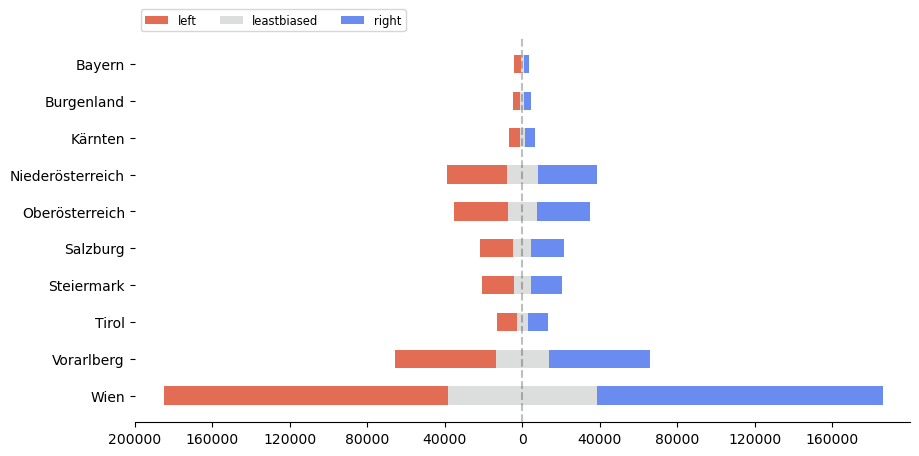

In [110]:
import numpy as np
import matplotlib.pyplot as plt


categories = list(cross_df.index)


def survey(results, category_names, row_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = row_names
    data = np.array(results.values.tolist())
    #print(data)
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-200000, 200000)
    ax.set_xticks(np.arange(-200000, 200000, 40000))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')

    return fig, ax


fig, ax = survey(cross_df, cross_df.columns, categories)

plt.show()

In [77]:
top_cities = top_cities.loc[top_cities.pol_label != 'unknown',]
top_cities.loc[top_cities.pol_label == 'extremeright', 'pol_label'] = 'right'
#top_cities.loc[top_cities.pol_label == 'leftcenter', 'pol_label'] = 'left'
#top_cities.loc[top_cities.pol_label == 'rightcenter', 'pol_label'] = 'right'
cross_df = pd.DataFrame(pd.crosstab(top_cities.User_Location, top_cities.pol_label))
#cross_df = cross_df[['left', 'leftcenter', 'leastbiased', 'rightcenter', 'right']]
cross_df = cross_df[['left', 'leastbiased', 'right']]
cross_df


pol_label,left,leastbiased,right
User_Location,,,
Dornbirn,406,5749,11052
Graz,300,4398,7562
Hard,262,3906,7057
Innsbruck,160,2330,4115
Lauterach,249,3328,6282
Linz,434,5906,10509
Lustenau,249,3416,6133
Salzburg,477,6908,12360
Schwarzach,154,2423,4319


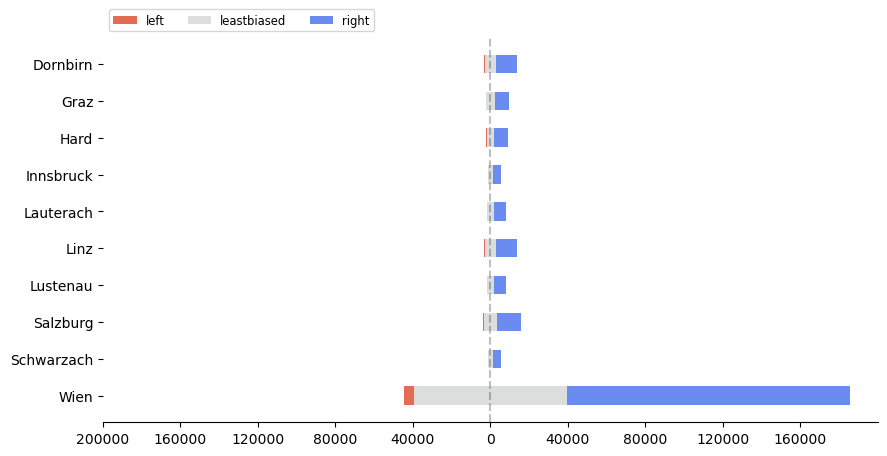

In [78]:
import numpy as np
import matplotlib.pyplot as plt


categories = list(cross_df.index)


def survey(results, category_names, row_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = row_names
    data = np.array(results.values.tolist())
    #print(data)
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-200000, 200000)
    ax.set_xticks(np.arange(-200000, 200000, 40000))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')

    return fig, ax


fig, ax = survey(cross_df, cross_df.columns, categories)

plt.show()

In [ ]:
df_dissim = pd.read_pickle('df_dissim_geo.pkl')
geo_acc_divs = geo_acc_div.merge(df_dissim, on='model')
geo_acc_divs['Diff Dissim'] = np.abs(geo_acc_divs['Dissim_O'] - geo_acc_divs['Dissim_BC'])
geo_acc_divs1 = geo_acc_divs[['model','Ent_O', 'Ent_BC', 'Diff Ent', 'Dissim_O',
       'Dissim_BC', 'Diff Dissim']]
geo_acc_divs1.style.format('{:,.5f}', subset=['Ent_O', 'Ent_BC', 'Diff Ent', 'Dissim_O',
       'Dissim_BC', 'Diff Dissim'])

,model,Ent_O,Ent_BC,Diff Ent,Dissim_O,Dissim_BC,Diff Dissim
0,FOCF_none,0.00620,0.00620,0.00000,0.93430,0.93438,0.00008
1,FOCF_value,0.00593,0.00611,0.00018,0.93785,0.93911,0.00126
2,FOCF_absolute,0.00610,0.00620,0.00010,0.93421,0.93398,0.00024
3,FOCF_nonparity,0.00617,0.00621,0.00004,0.93388,0.93453,0.00065
4,FOCF_under,0.00620,0.00640,0.00020,0.93330,0.93513,0.00183
5,FOCF_over,0.00617,0.00620,0.00004,0.93430,0.93438,0.00008
6,PFCN_BiasedMF,0.00600,0.00610,0.00010,0.94156,0.93874,0.00282
7,PFCN_PMF,0.00610,0.00600,0.00010,0.93984,0.93819,0.00165
8,PFCN_MLP,0.00620,0.00620,0.00000,0.93902,0.94006,0.00104
9,PFCN_DMF,0.00620,0.00610,0.00010,0.94277,0.94496,0.00219


In [ ]:
geo_acc_divs.columns

Index(['model', 'Ent_O', 'Ent_BC', 'Diff Ent', 'Dissim_O', 'Dissim_BC',
       'Diff Dissim'],
      dtype='object')

### Pivot to grouping users by political interest

In [336]:
df_full['pol_label_num'] = 0
df_full.loc[df_full.pol_label.isin(['extremeright','rightcenter','right']),'pol_label_num'] = 1
df_full.loc[df_full.pol_label.isin(['leftcenter','left']),'pol_label_num'] = -1

In [346]:
df_user_pol = df_full.groupby(['ID_User'])['pol_label_num'].sum().to_frame()


In [347]:
df_user_pol['ID_User'] = df_user_pol.index
df_user_pol.columns = ['pol_label_usersum','ID_User']
df_user_pol = df_user_pol.reset_index(drop=True)
#df_user_pol['User_Location'] = df_user_pol['User_Location'].astype("string")
df_user_pol

,pol_label_usersum,ID_User
0,2,7.0
1,-2,19.0
2,0,24.0
3,0,27.0
4,-1,37.0
...,...,...
124062,0,858888.0
124063,-5,858890.0
124064,1,858895.0
124065,0,858906.0


In [171]:
df_full = pd.merge(df_full, df_user_pol, how = 'left', on = 'ID_User')

In [348]:
df_user_pol = pd.merge(df_user_pol, df_user_location, how = 'inner', on = 'ID_User')
df_user_pol.shape

(124067, 3)

In [349]:
#df_user_pol['pol_group'] = pd.cut(df_user_pol.pol_label_usersum, bins = [-46,-10,-4,-1,0,3,9,45], 
#                                    labels = ['-45 -10', '-9 -4', '-3 -1', '0', '1 3', '4 9', '10+'])
df_user_pol['pol_group'] = pd.cut(df_user_pol.pol_label_usersum, bins = [-46,-4,-1,0,3,45])
df_user_pol_sub = df_user_pol.loc[df_user_pol.User_Location.isin(top5_cities),]

In [352]:
df_user_pol.head()

,pol_label_usersum,ID_User,User_Location,pol_group
0,2,7.0,Wien,"(0, 3]"
1,-2,19.0,Wien,"(-4, -1]"
2,0,24.0,Dornbirn,"(-1, 0]"
3,0,27.0,Linz,"(-1, 0]"
4,-1,37.0,Pölten,"(-4, -1]"


In [350]:
pd.DataFrame(pd.crosstab(df_user_pol_sub.User_Location,df_user_pol_sub.pol_group, normalize = 'index'))

pol_group,"(-46, -4]","(-4, -1]","(-1, 0]","(0, 3]","(3, 45]"
User_Location,,,,,
Dornbirn,0.056434,0.241322,0.355608,0.284298,0.062338
Graz,0.061704,0.268364,0.347698,0.267058,0.055175
Linz,0.063953,0.266936,0.329879,0.278311,0.060920
Salzburg,0.065820,0.261376,0.349206,0.263069,0.060529
Wien,0.066173,0.255815,0.325709,0.284579,0.067724


In [206]:
cross_df = pd.DataFrame(pd.crosstab(df_user_pol_sub.User_Location, df_user_pol_sub.pol_group, normalize = 'index'))

In [353]:
users_left = df_user_pol.loc[df_user_pol.pol_label_usersum <=-5,'ID_User']
users_right = df_user_pol.loc[df_user_pol.pol_label_usersum >=5,'ID_User']

In [355]:
calc_entropy(df_full.loc[df_full.ID_User.isin(users_left),])

11.321563000929073

In [356]:
calc_entropy(df_full.loc[df_full.ID_User.isin(users_right),])

10.9243745005776

In [ ]:



# Load the data into a pandas dataframe
df = pd.read_csv('data.csv', names=['user', 'item', 'gender'])

# Calculate the total number of views
total_views = df.shape[0]

# Group the data by item and count the number of views for each item
item_counts = df.groupby('item').size()

# Calculate the probability of each item
item_probs = item_counts / total_views

# Calculate the entropy for each item
item_entropy = -item_probs * item_probs.apply(math.log2)

# Calculate the overall entropy
overall_entropy = item_entropy.sum()

# Print the results
print('Entropy split by item:')
print(item_entropy)
print('Overall entropy:', overall_entropy)

In [243]:
import math
from scipy.stats import entropy
import torch
from collections import Counter

In [231]:


# Calculate the total number of views
total_views = df_full.shape[0]

# Group the data by item and count the number of views for each item
item_counts = df_full.groupby('SID_Content').size()

# Calculate the probability of each item
item_probs = item_counts / total_views

# Calculate the entropy for each item
item_entropy = -item_probs * item_probs.apply(math.log2)

# Calculate the overall entropy
overall_entropy = item_entropy.sum()

H = entropy(item_probs, base=2)
H2 = -np.sum(item_probs * np.log(item_probs)) / np.log(2)

#H = entropy(item_probs, base=2)

#H == -np.sum(item_probs * np.log(item_probs)) / np.log(2)
# Print the results
#print('Entropy split by item:')
#print(item_entropy)
print('Overall entropy:', overall_entropy, '/', H, H2)


Overall entropy: 11.164989929081127 / 11.164989929081129 11.164989929081129


In [247]:
item_matrix = torch.load(r'C:\Users\e12139066\Documents\Thesis\RecBole-FairRec-master\rec_items\Feb-21-2023_23-10-11_rec_items_colab.pt')

In [266]:
item_count = dict(Counter(item_matrix.flatten()))
total_num = item_matrix.shape[0] * item_matrix.shape[1]
result = 0.0
for cnt in item_count.values():
    p = cnt / total_num
    result += -p * np.log(p)
result*10 / len(item_count)

0.002163955656884788

In [253]:
item_df = pd.DataFrame(item_matrix.flatten())

In [257]:
item_df.columns = ['SID_Content']

In [323]:
def calc_entropy(df):
    # Calculate the total number of views
    total_views = df.shape[0]

    # Group the data by item and count the number of views for each item
    item_counts = df.groupby('SID_Content').size()

    # Calculate the probability of each item
    item_probs = item_counts / total_views

    # Calculate the entropy for each item
    item_entropy = -item_probs * item_probs.apply(math.log2)

    # Calculate the overall entropy
    overall_entropy = item_entropy.sum()
    return(overall_entropy)




In [271]:
6.0196/0.0021537179

2794.980716833899

In [272]:
#2821 They divide by this for some reason


2810.9916194885213